<a href="https://colab.research.google.com/github/zakyzuf/convnext-scabies-detection/blob/main/research/notebook/scabies_convnext_pytorch_80_10_10_epoch10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# dataset
scabies_dir = '/content/drive/MyDrive/Skripsi/dataset/scabies/scabies-crop'
non_scabies_dir = '/content/drive/MyDrive/Skripsi/dataset/non-scabies-and-healty-skin'

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Target size untuk resize (didefinisikan di awal agar bisa digunakan di semua bagian)
IMG_SIZE = 224

# List semua file gambar dari kedua direktori
scabies_images = [os.path.join(scabies_dir, x) for x in os.listdir(scabies_dir)]
non_scabies_images = [os.path.join(non_scabies_dir, x) for x in os.listdir(non_scabies_dir)]

# Buat label untuk masing-masing gambar
scabies_labels = [1] * len(scabies_images)  # 1 untuk scabies
non_scabies_labels = [0] * len(non_scabies_images)  # 0 untuk non-scabies

# Gabungkan semua data
all_images = scabies_images + non_scabies_images
all_labels = scabies_labels + non_scabies_labels

# Bagi dataset: 80% train, 10% validation, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    all_images,
    all_labels,
    test_size=0.10,
    random_state=42,
    stratify=all_labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.125,   # 10/80 ≈ 0.125
    random_state=42,
    stratify=y_temp
)

print(f"Jumlah data train: {len(X_train)}")
print(f"Jumlah data validation: {len(X_val)}")
print(f"Jumlah data test: {len(X_test)}")

# Distribusi kelas
print("\nDistribusi kelas di data train:")
print(f"Scabies: {sum(y_train)}")
print(f"Non-scabies: {len(y_train) - sum(y_train)}")

print("\nDistribusi kelas di data validation:")
print(f"Scabies: {sum(y_val)}")
print(f"Non-scabies: {len(y_val) - sum(y_val)}")

print("\nDistribusi kelas di data test:")
print(f"Scabies: {sum(y_test)}")
print(f"Non-scabies: {len(y_test) - sum(y_test)}")

Jumlah data train: 644
Jumlah data validation: 93
Jumlah data test: 82

Distribusi kelas di data train:
Scabies: 384
Non-scabies: 260

Distribusi kelas di data validation:
Scabies: 55
Non-scabies: 38

Distribusi kelas di data test:
Scabies: 49
Non-scabies: 33


In [5]:
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm

# Function untuk membaca dan resize gambar
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

# Pipeline augmentasi
augmentations = [
    A.Rotate(limit=[90, 90], p=1.0),              # Rotasi 90° searah jarum jam
    A.Rotate(limit=[-90, -90], p=1.0),            # Rotasi 90° berlawanan jarum jam
    A.HorizontalFlip(p=1.0),                      # Flip horizontal
    A.VerticalFlip(p=1.0)                         # Flip vertikal
]

# Function untuk augmentasi satu gambar
def augment_image(image, augmentation):
    augmented = augmentation(image=image)
    return augmented['image']

# === MEMUAT DAN MENGAUGMENTASI TRAINING SET ===
augmented_images = []
augmented_labels = []

print("Melakukan augmentasi data training...")
for img_path, label in tqdm(zip(X_train, y_train)):
    # Baca dan resize gambar asli
    image = load_image(img_path)

    # Tambahkan gambar asli
    augmented_images.append(image)
    augmented_labels.append(label)

    # Lakukan setiap jenis augmentasi
    for aug in augmentations:
        transform = A.Compose([aug])
        aug_image = augment_image(image, transform)
        augmented_images.append(aug_image)
        augmented_labels.append(label)

# Konversi ke numpy array
X_train_augmented = np.array(augmented_images)
y_train_augmented = np.array(augmented_labels)

print(f"Shape data training setelah augmentasi: {X_train_augmented.shape}")
print(f"Jumlah data training sebelum augmentasi: {len(X_train)}")
print(f"Jumlah data training setelah augmentasi: {len(X_train_augmented)}")

# Distribusi kelas setelah augmentasi
print("\nDistribusi kelas setelah augmentasi:")
print(f"Scabies: {sum(y_train_augmented)}")
print(f"Non-scabies: {len(y_train_augmented) - sum(y_train_augmented)}")

# === MEMUAT VALIDATION SET (TANPA AUGMENTASI) ===
print("Memuat data validation...")
X_val_array = np.array([load_image(path) for path in X_val])
y_val_array = np.array(y_val)

# === MEMUAT TEST SET (TANPA AUGMENTASI) ===
print("Memuat data test...")
X_test_array = np.array([load_image(path) for path in X_test])
y_test_array = np.array(y_test)

# Normalisasi data
X_train_norm = X_train_augmented / 255.0
X_val_norm = X_val_array / 255.0
X_test_norm = X_test_array / 255.0

Melakukan augmentasi data training...


644it [02:17,  4.69it/s]


Shape data training setelah augmentasi: (3220, 224, 224, 3)
Jumlah data training sebelum augmentasi: 644
Jumlah data training setelah augmentasi: 3220

Distribusi kelas setelah augmentasi:
Scabies: 1920
Non-scabies: 1300
Memuat data validation...
Memuat data test...


Using device: cuda


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 156MB/s]


Model loaded.
Total parameters: 27821666
Starting training...
Epoch 1/10
----------


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.1429 Acc: 0.9429


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Val Loss: 0.2929 Acc: 0.9032
Epoch 2/10
----------


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0221 Acc: 0.9935


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Val Loss: 0.1549 Acc: 0.9570
Epoch 3/10
----------


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0014 Acc: 1.0000


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Val Loss: 0.1463 Acc: 0.9570
Epoch 4/10
----------


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0017 Acc: 0.9994


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Val Loss: 0.4682 Acc: 0.9140
Epoch 5/10
----------


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0440 Acc: 0.9848


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Val Loss: 0.1817 Acc: 0.9570
Epoch 6/10
----------


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0108 Acc: 0.9960


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Val Loss: 0.3439 Acc: 0.9355
Epoch 7/10
----------


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0067 Acc: 0.9975


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Val Loss: 0.2730 Acc: 0.9570
Epoch 8/10
----------


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0025 Acc: 0.9997


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Val Loss: 0.2593 Acc: 0.9570
Epoch 9/10
----------


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0031 Acc: 0.9994


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Val Loss: 0.2604 Acc: 0.9462
Epoch 10/10
----------


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0141 Acc: 0.9947


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Val Loss: 0.2735 Acc: 0.9140
Training complete in 8m 17s
Best val Acc: 0.9570


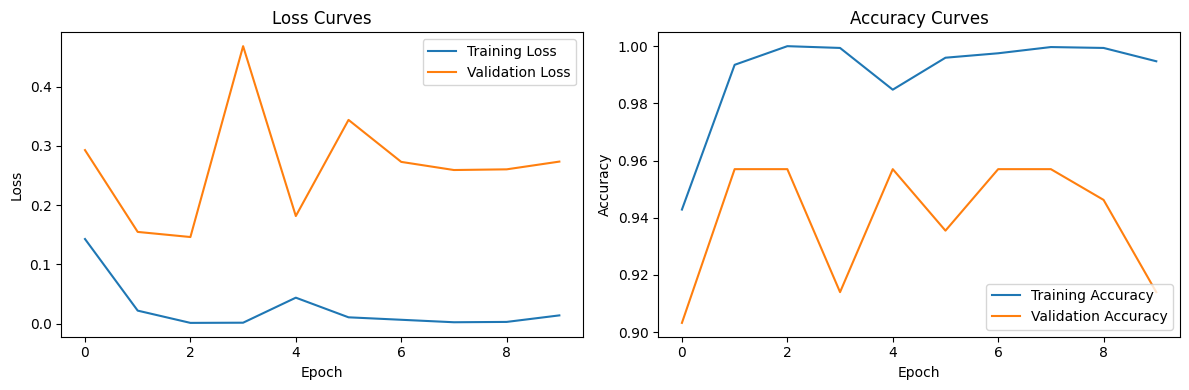

Evaluating on test set...


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Confusion Matrix:
[[33  0]
 [ 2 47]]


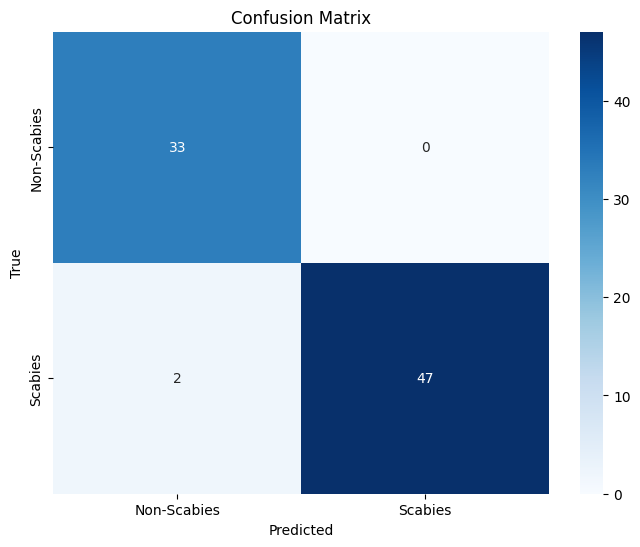


Classification Report:
              precision    recall  f1-score   support

 Non-Scabies       0.94      1.00      0.97        33
     Scabies       1.00      0.96      0.98        49

    accuracy                           0.98        82
   macro avg       0.97      0.98      0.97        82
weighted avg       0.98      0.98      0.98        82



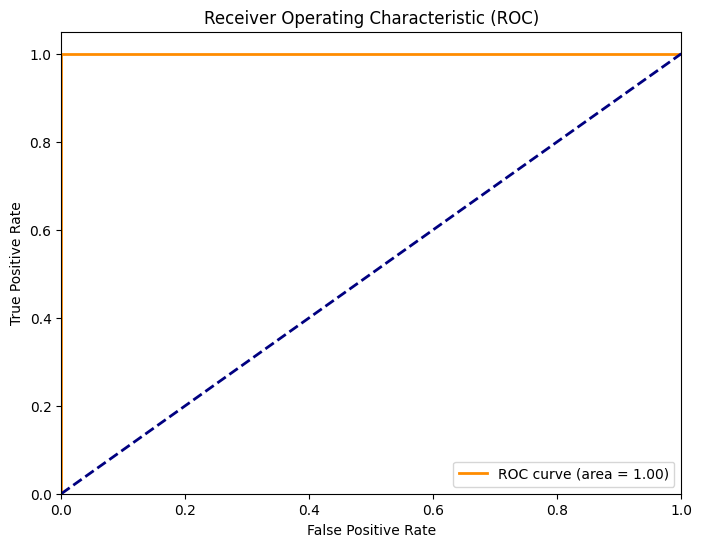

Evaluasi model pada test set...


Testing:   0%|          | 0/3 [00:00<?, ?it/s]


Contoh Prediksi Acak:


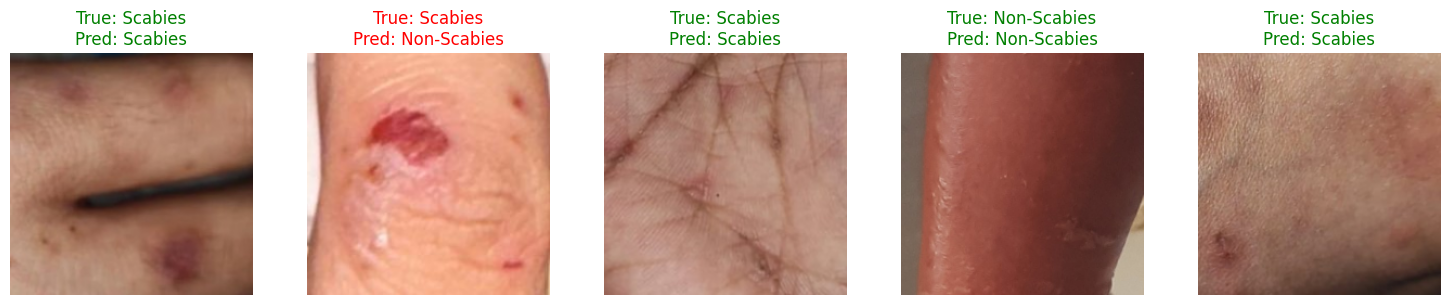


Contoh Prediksi yang Salah:


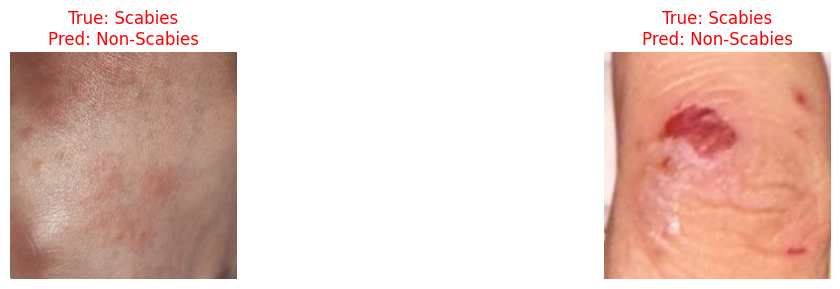

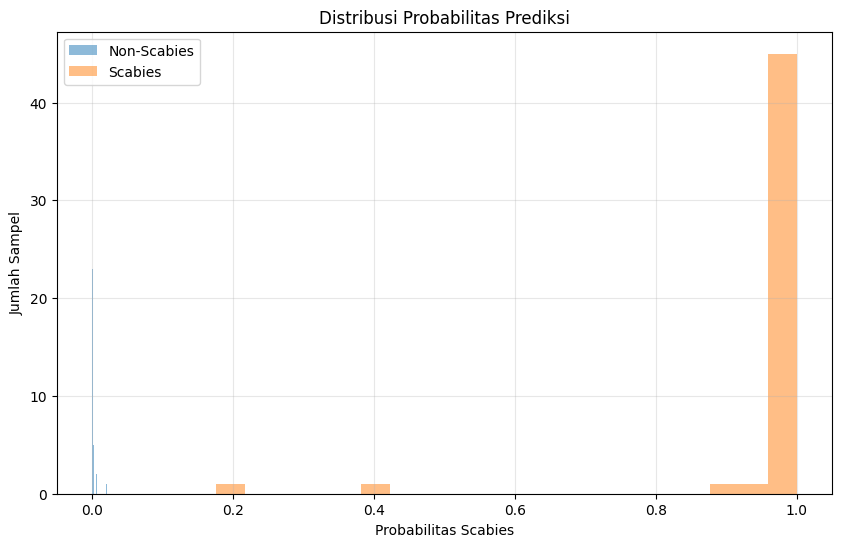

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from tqdm.notebook import tqdm
import time
import copy

# Konstanta
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Custom Dataset untuk data yang sudah di-preprocess
class ScabiesDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.from_numpy(images).permute(0, 3, 1, 2).float()  # Convert to NCHW format
        self.labels = torch.from_numpy(labels).long()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Buat dataset dan dataloader
train_dataset = ScabiesDataset(X_train_norm, y_train_augmented)
val_dataset = ScabiesDataset(X_val_norm, y_val_array)
test_dataset = ScabiesDataset(X_test_norm, y_test_array)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Bangun model ConvNeXt
model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Modifikasi fully connected layer terakhir untuk klasifikasi binary
num_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_features, 2)  # 2 kelas: scabies dan non-scabies
model = model.to(DEVICE)

print("Model loaded.")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Untuk tracking metrics
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Training loop
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

print("Starting training...")
start_time = time.time()

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    # Iterate over training data
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward + optimize
        loss.backward()
        optimizer.step()

        # Statistik
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc.item())

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # No gradients needed
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistik
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)

    history['val_loss'].append(epoch_loss)
    history['val_acc'].append(epoch_acc.item())

    print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Deep copy the model if best accuracy
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - start_time
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:.4f}')

# Load best model weights
model.load_state_dict(best_model_wts)

# Plot learning curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluasi pada test set
print("Evaluating on test set...")
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilitas kelas positif (scabies)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Scabies', 'Scabies'],
            yticklabels=['Non-Scabies', 'Scabies'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Non-Scabies', 'Scabies']))

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Evaluasi pada test set
print("Evaluasi model pada test set...")
model.eval()

test_preds = []
test_labels = []
test_probs = []
all_test_images = []  # Untuk menyimpan gambar asli dari test set

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Simpan gambar asli (pindahkan ke CPU dan konversi ke numpy untuk plotting)
        all_test_images.append(inputs.cpu().numpy())

        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs[:, 1].cpu().numpy())  # Probabilitas kelas positif (scabies)

# Gabungkan semua batch gambar test
all_test_images = np.vstack([img for img in all_test_images])

# Konversi gambar kembali ke format yang bisa ditampilkan (NCHW -> NHWC)
all_test_images = all_test_images.transpose(0, 2, 3, 1)  # NCHW -> NHWC

# Fungsi untuk menampilkan prediksi pada gambar test
def plot_predictions(images, true_labels, pred_labels, num_images=5, indices=None):
    # Jika tidak ada indeks spesifik yang diberikan, pilih secara acak
    if indices is None:
        indices = np.random.choice(len(images), min(num_images, len(images)), replace=False)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i+1)

        # Tampilkan gambar
        plt.imshow(images[idx])
        plt.axis('off')

        true_label = 'Scabies' if true_labels[idx] == 1 else 'Non-Scabies'
        pred_label = 'Scabies' if pred_labels[idx] == 1 else 'Non-Scabies'
        color = 'green' if true_labels[idx] == pred_labels[idx] else 'red'
        plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)

    plt.tight_layout()
    plt.show()

# Tampilkan beberapa contoh prediksi acak
print("\nContoh Prediksi Acak:")
plot_predictions(all_test_images, test_labels, test_preds, num_images=5)

# Temukan contoh prediksi yang salah (jika ada)
incorrect_indices = np.where(np.array(test_labels) != np.array(test_preds))[0]
if len(incorrect_indices) > 0:
    print("\nContoh Prediksi yang Salah:")
    plot_predictions(all_test_images, test_labels, test_preds,
                    num_images=min(5, len(incorrect_indices)),
                    indices=incorrect_indices[:5])
else:
    print("\nTidak ada prediksi yang salah pada test set!")

# Tampilkan distribusi probabilitas
plt.figure(figsize=(10, 6))
plt.hist(np.array(test_probs)[np.array(test_labels) == 0], alpha=0.5, bins=20, label='Non-Scabies')
plt.hist(np.array(test_probs)[np.array(test_labels) == 1], alpha=0.5, bins=20, label='Scabies')
plt.xlabel('Probabilitas Scabies')
plt.ylabel('Jumlah Sampel')
plt.title('Distribusi Probabilitas Prediksi')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Lalu simpan model
torch.save(model.state_dict(), 'scabies_convnext_model_80_10_10_epoch10.pth')

In [7]:
# Import torchsummary
from torchsummary import summary

# Tampilkan summary model (input size harus sesuai dengan ukuran gambar Anda, misalnya 3x224x224)
print("Model Summary:")
summary(model, (3, 224, 224))

print("\nDetail struktur model:")
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14    